In [17]:
import os
import chess
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
from chess_workhorse_tools import *
from dynamic_depth import *
import chess.pgn
import pickle

In [2]:
df = pd.read_csv('clean_first_chess_data.csv')
df.head()

,chess,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,NaN,Unnamed: 0,Unnamed: 0.1,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
1,0.0,0,0,TZJHLljE,FALSE,1504210000000.0,1504210000000.0,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
2,1.0,1,1,l1NXvwaE,TRUE,1504130000000.0,1504130000000.0,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
3,2.0,2,2,mIICvQHh,TRUE,1504130000000.0,1504130000000.0,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
4,3.0,3,3,kWKvrqYL,TRUE,1504110000000.0,1504110000000.0,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3


In [3]:
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

In [4]:
df_moves = df['moves'].tolist()
moves = [move.split() for move in df_moves]
moves[:2]

[['d4',
  'd5',
  'c4',
  'c6',
  'cxd5',
  'e6',
  'dxe6',
  'fxe6',
  'Nf3',
  'Bb4+',
  'Nc3',
  'Ba5',
  'Bf4'],
 ['d4',
  'Nc6',
  'e4',
  'e5',
  'f4',
  'f6',
  'dxe5',
  'fxe5',
  'fxe5',
  'Nxe5',
  'Qd4',
  'Nc6',
  'Qe5+',
  'Nxe5',
  'c4',
  'Bb4+']]

In [5]:
df_winner = df['winner'].tolist()
def one_hot_result(result):
    if result == 'white':
        return 1
    if result == 'draw':
        return 0
    if result == 'black':
        return -1
results = [one_hot_result(winner) for winner in df_winner]
results[:10]

[1, -1, 1, 1, 1, 0, 1, -1, -1, 1]

In [6]:
#I want to use moves as the training data and results as the target.

In [5]:
chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
}
alpha_dict = {
    'a' : [0,0,0,0,0,0,0],
    'b' : [1,0,0,0,0,0,0],
    'c' : [0,1,0,0,0,0,0],
    'd' : [0,0,1,0,0,0,0],
    'e' : [0,0,0,1,0,0,0],
    'f' : [0,0,0,0,1,0,0],
    'g' : [0,0,0,0,0,1,0],
    'h' : [0,0,0,0,0,0,1],
}
number_dict = {
    1 : [0,0,0,0,0,0,0],
    2 : [1,0,0,0,0,0,0],
    3 : [0,1,0,0,0,0,0],
    4 : [0,0,1,0,0,0,0],
    5 : [0,0,0,1,0,0,0],
    6 : [0,0,0,0,1,0,0],
    7 : [0,0,0,0,0,1,0],
    8 : [0,0,0,0,0,0,1],
}

In [6]:
def make_matrix(board): 
    fen = board.epd()
    outer_list = []  
    pieces = fen.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        inner_list = []  
        for entry in row:
            if entry.isdigit():
                for i in range(0, int(entry)):
                    inner_list.append('.')
            else:
                inner_list.append(entry)
        outer_list.append(inner_list)
    return outer_list
def translate(matrix,chess_dict):
    rows = []
    for row in matrix:
        terms = []
        for term in row:
            terms.append(chess_dict[term])
        rows.append(terms)
    return rows

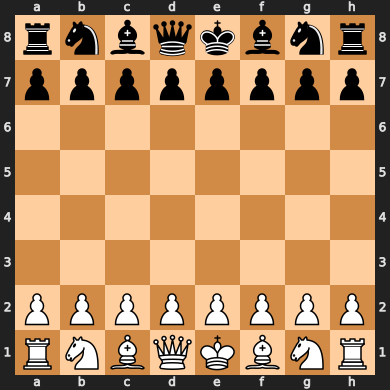

In [9]:
#Quick demo of these functions
board = chess.Board()
board

In [10]:
#This function creates a "matrix" board
sample_matrix = make_matrix(board)
sample_matrix

[['r', 'n', 'b', 'q', 'k', 'b', 'n', 'r'],
 ['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p'],
 ['.', '.', '.', '.', '.', '.', '.', '.'],
 ['.', '.', '.', '.', '.', '.', '.', '.'],
 ['.', '.', '.', '.', '.', '.', '.', '.'],
 ['.', '.', '.', '.', '.', '.', '.', '.'],
 ['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P'],
 ['R', 'N', 'B', 'Q', 'K', 'B', 'N', 'R']]

In [11]:
#This function one hot encodes each row
translate(sample_matrix,chess_dict)

[[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [12]:
#This Just simplifies things to see if it works. 1000 is even a lot tbh
some_moves = df['moves'].tolist()[:1000]
split_data = []
indice = 1000

for point in some_moves[:1000]:
    point = point.split()
    split_data.append(point)

#This does all the moves and will crash your computer
# all_moves = df['moves'].tolist()
# split_data = []
# for point in all_moves:
#     point = point.split()
#     split_data.append(point)
    
data = []
for game in split_data:
    board = chess.Board()
    for move in game:
        board_ready = board.copy()
        data.append(board.copy())
        board.push_san(move)
trans_data = []
for board in data:
    matrix = make_matrix(board)
    trans = translate(matrix,chess_dict)
    trans_data.append(trans)

In [13]:
split_data[0]

['d4',
 'd5',
 'c4',
 'c6',
 'cxd5',
 'e6',
 'dxe6',
 'fxe6',
 'Nf3',
 'Bb4+',
 'Nc3',
 'Ba5',
 'Bf4']

In [14]:
pieces = []
alphas = []
numbers = []
for row in split_data:
    for entry in row:
        try:
            term = entry
            term = term.replace('x','')
            term = term.replace('#','')
            term = term.replace('+','')
            if len(term) == 2:
                piece = 'p' 
            else:
                piece = term[0]
            alpha = term[-2]
            number = term[-1]
            pieces.append(chess_dict[piece])
            alphas.append(alpha_dict[alpha])
            numbers.append(number_dict[int(number)])
        except:
            pass

In [15]:
len(numbers)

53024

In [7]:
board_inputs = keras.Input(shape=(8, 8, 12))
conv1= keras.layers.Conv2D(10, 3, activation='relu')
conv2 = keras.layers.Conv2D(10, 3, activation='relu')
pooling1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None,)
pooling2 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None,)
flatten = keras.layers.Flatten(data_format=None)
x = conv1(board_inputs)
x = pooling1(x)
x = conv2(x)
x = flatten(x)
piece_output = keras.layers.Dense(12,name = 'piece')(x)
model_pieces = keras.Model(inputs=board_inputs, outputs=piece_output, name="chess_ai_v3")
earlystop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=250, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model_pieces.compile(
    loss=keras.losses.mse,
    optimizer=keras.optimizers.Adam(),
    metrics=None,
)

In [17]:
model_pieces.fit(trans_data[:len(pieces)],pieces[:len(pieces)], batch_size=64, epochs=50,callbacks = [earlystop])

Epoch 1/50
829/829 [==============================] - 2s 2ms/step - loss: 0.0698
Epoch 2/50
829/829 [==============================] - 2s 2ms/step - loss: 0.0688
Epoch 3/50
829/829 [==============================] - 2s 2ms/step - loss: 0.0687
Epoch 4/50
829/829 [==============================] - 2s 2ms/step - loss: 0.0686
Epoch 5/50
829/829 [==============================] - 2s 2ms/step - loss: 0.0685
Epoch 6/50
829/829 [==============================] - 2s 2ms/step - loss: 0.0684
Epoch 7/50
829/829 [==============================] - 2s 2ms/step - loss: 0.0683
Epoch 8/50
829/829 [==============================] - 1s 2ms/step - loss: 0.0682
Epoch 9/50
829/829 [==============================] - 1s 2ms/step - loss: 0.0681
Epoch 10/50
829/829 [==============================] - 1s 2ms/step - loss: 0.0681
Epoch 11/50
829/829 [==============================] - 1s 2ms/step - loss: 0.0680
Epoch 12/50
829/829 [==============================] - 1s 2ms/step - loss: 0.0680
Epoch 13/50
829/829 [====

In [8]:
board_inputs = keras.Input(shape=(8, 8, 12))
conv1= keras.layers.Conv2D(10, 3, activation='relu')
conv2 = keras.layers.Conv2D(10, 3, activation='relu')
pooling1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None,)
pooling2 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None,)
flatten = keras.layers.Flatten(data_format=None)
x = conv1(board_inputs)
x = pooling1(x)
x = conv2(x)
x = flatten(x)
alpha_output = keras.layers.Dense(7,name = 'alpha')(x)
model_alpha = keras.Model(inputs=board_inputs, outputs=alpha_output, name="chess_ai_v3")
earlystop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=250, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model_alpha.compile(
    loss=keras.losses.mse,
    optimizer=keras.optimizers.Adam(),
    metrics=None,
)

In [19]:
model_alpha.fit(trans_data[:len(alphas)],alphas[:len(alphas)],batch_size=64, epochs=50,callbacks = [earlystop])

Epoch 1/50
829/829 [==============================] - 1s 1ms/step - loss: 0.1150
Epoch 2/50
829/829 [==============================] - 1s 2ms/step - loss: 0.1137
Epoch 3/50
829/829 [==============================] - 1s 1ms/step - loss: 0.1136
Epoch 4/50
829/829 [==============================] - 1s 1ms/step - loss: 0.1136
Epoch 5/50
829/829 [==============================] - 1s 2ms/step - loss: 0.1135
Epoch 6/50
829/829 [==============================] - 1s 2ms/step - loss: 0.1135
Epoch 7/50
829/829 [==============================] - 1s 2ms/step - loss: 0.1134
Epoch 8/50
829/829 [==============================] - 1s 2ms/step - loss: 0.1134
Epoch 9/50
829/829 [==============================] - 1s 2ms/step - loss: 0.1133
Epoch 10/50
829/829 [==============================] - 1s 2ms/step - loss: 0.1132
Epoch 11/50
829/829 [==============================] - 1s 2ms/step - loss: 0.1132
Epoch 12/50
829/829 [==============================] - 2s 2ms/step - loss: 0.1131
Epoch 13/50
829/829 [====

In [9]:
board_inputs = keras.Input(shape=(8, 8, 12))
conv1= keras.layers.Conv2D(10, 3, activation='relu')
conv2 = keras.layers.Conv2D(10, 3, activation='relu')
pooling1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None,)
pooling2 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None,)
flatten = keras.layers.Flatten(data_format=None)
x = conv1(board_inputs)
x = pooling1(x)
x = conv2(x)
x = flatten(x)
numbers_output = keras.layers.Dense(7,name = 'number')(x)
model_number = keras.Model(inputs=board_inputs, outputs=numbers_output, name="chess_ai_v3")
earlystop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=250, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model_number.compile(
    loss=keras.losses.mse,
    optimizer=keras.optimizers.Adam(),
    metrics=None,
)

In [21]:
model_number.fit(trans_data[:len(numbers)],numbers[:len(numbers)],batch_size=64, epochs=50,callbacks = [earlystop])

Epoch 1/50
829/829 [==============================] - 1s 2ms/step - loss: 0.1150
Epoch 2/50
829/829 [==============================] - 1s 2ms/step - loss: 0.1137
Epoch 3/50
829/829 [==============================] - 1s 2ms/step - loss: 0.1135
Epoch 4/50
829/829 [==============================] - 1s 2ms/step - loss: 0.1135
Epoch 5/50
829/829 [==============================] - 1s 2ms/step - loss: 0.1134
Epoch 6/50
829/829 [==============================] - 1s 2ms/step - loss: 0.1134
Epoch 7/50
829/829 [==============================] - 1s 2ms/step - loss: 0.1134
Epoch 8/50
829/829 [==============================] - 1s 2ms/step - loss: 0.1133
Epoch 9/50
829/829 [==============================] - 1s 2ms/step - loss: 0.1133
Epoch 10/50
829/829 [==============================] - 1s 2ms/step - loss: 0.1132
Epoch 11/50
829/829 [==============================] - 1s 2ms/step - loss: 0.1132
Epoch 12/50
829/829 [==============================] - 2s 2ms/step - loss: 0.1131
Epoch 13/50
829/829 [====

In [10]:
#Now keep training it on new data

some_moves = df['moves'].tolist()[:4000]
split_data = []

for point in some_moves:
    point = point.split()
    split_data.append(point)
    
data = []
for game in split_data:
    board = chess.Board()
    for move in game:
        board_ready = board.copy()
        data.append(board.copy())
        board.push_san(move)
trans_data = []

for board in data:
    matrix = make_matrix(board)
    trans = translate(matrix,chess_dict)
    trans_data.append(trans)
pieces = []
alphas = []
numbers = []
for row in split_data:
    for entry in row:
        try:
            term = entry
            term = term.replace('x','')
            term = term.replace('#','')
            term = term.replace('+','')
            if len(term) == 2:
                piece = 'p' 
            else:
                piece = term[0]
            alpha = term[-2]
            number = term[-1]
            pieces.append(chess_dict[piece])
            alphas.append(alpha_dict[alpha])
            numbers.append(number_dict[int(number)])
        except:
            pass

In [11]:
model_pieces.fit(trans_data[:len(pieces)],pieces[:len(pieces)], batch_size=64, epochs=50,callbacks = [earlystop])

Epoch 1/50
3400/3400 [==============================] - 9s 3ms/step - loss: 0.0693
Epoch 2/50
3400/3400 [==============================] - 7s 2ms/step - loss: 0.0689
Epoch 3/50
3400/3400 [==============================] - 8s 2ms/step - loss: 0.0689
Epoch 4/50
3400/3400 [==============================] - 8s 2ms/step - loss: 0.0689
Epoch 5/50
3400/3400 [==============================] - 8s 2ms/step - loss: 0.0688
Epoch 6/50
3400/3400 [==============================] - 7s 2ms/step - loss: 0.0688
Epoch 7/50
3400/3400 [==============================] - 7s 2ms/step - loss: 0.0687
Epoch 8/50
3400/3400 [==============================] - 7s 2ms/step - loss: 0.0687
Epoch 9/50
3400/3400 [==============================] - 7s 2ms/step - loss: 0.0687
Epoch 10/50
3400/3400 [==============================] - 9s 3ms/step - loss: 0.0687
Epoch 11/50
3400/3400 [==============================] - 8s 2ms/step - loss: 0.0686
Epoch 12/50
3400/3400 [==============================] - 8s 2ms/step - loss: 0.0686
E

In [12]:
model_alpha.fit(trans_data[:len(alphas)],alphas[:len(alphas)], batch_size=64, epochs=50,callbacks = [earlystop])

Epoch 1/50
3399/3399 [==============================] - 7s 2ms/step - loss: 0.1144
Epoch 2/50
3399/3399 [==============================] - 8s 2ms/step - loss: 0.1139
Epoch 3/50
3399/3399 [==============================] - 7s 2ms/step - loss: 0.1139
Epoch 4/50
3399/3399 [==============================] - 8s 2ms/step - loss: 0.1139
Epoch 5/50
3399/3399 [==============================] - 7s 2ms/step - loss: 0.1138
Epoch 6/50
3399/3399 [==============================] - 9s 3ms/step - loss: 0.1138
Epoch 7/50
3399/3399 [==============================] - 8s 2ms/step - loss: 0.1138
Epoch 8/50
3399/3399 [==============================] - 8s 2ms/step - loss: 0.1138
Epoch 9/50
3399/3399 [==============================] - 8s 2ms/step - loss: 0.1137
Epoch 10/50
3399/3399 [==============================] - 9s 3ms/step - loss: 0.1137
Epoch 11/50
3399/3399 [==============================] - 8s 2ms/step - loss: 0.1137
Epoch 12/50
3399/3399 [==============================] - 8s 2ms/step - loss: 0.1137
E

In [13]:
model_number.fit(trans_data[:len(numbers)],numbers[:len(numbers)], batch_size=64, epochs=50,callbacks = [earlystop])

Epoch 1/50
3399/3399 [==============================] - 9s 3ms/step - loss: 0.1141
Epoch 2/50
3399/3399 [==============================] - 9s 3ms/step - loss: 0.1137
Epoch 3/50
3399/3399 [==============================] - 9s 3ms/step - loss: 0.1137
Epoch 4/50
3399/3399 [==============================] - 8s 2ms/step - loss: 0.1137
Epoch 5/50
3399/3399 [==============================] - 8s 2ms/step - loss: 0.1136
Epoch 6/50
3399/3399 [==============================] - 8s 2ms/step - loss: 0.1136
Epoch 7/50
3399/3399 [==============================] - 9s 3ms/step - loss: 0.1136
Epoch 8/50
3399/3399 [==============================] - 8s 2ms/step - loss: 0.1136
Epoch 9/50
3399/3399 [==============================] - 7s 2ms/step - loss: 0.1136
Epoch 10/50
3399/3399 [==============================] - 7s 2ms/step - loss: 0.1136
Epoch 11/50
3399/3399 [==============================] - 7s 2ms/step - loss: 0.1136
Epoch 12/50
3399/3399 [==============================] - 6s 2ms/step - loss: 0.1136
E

In [20]:
#Turn all three into JSON

model_pieces_json = model_pieces.to_json()
with open("model_pieces.json", "w") as json_file:
    json_file.write(model_pieces_json)
# serialize weights to HDF5
model_pieces.save_weights("model_pieces_weights.h5")

model_alpha_json = model_alpha.to_json()
with open("model_alpha.json", "w") as json_file:
    json_file.write(model_alpha_json)
# serialize weights to HDF5
model_alpha.save_weights("model_alpha_weights.h5")

model_number_json = model_number.to_json()
with open("model_number.json", "w") as json_file:
    json_file.write(model_number_json)
# serialize weights to HDF5
model_number.save_weights("model_number_weights.h5")

In [22]:
new_chess_dict = {}
new_alpha_dict = {}
new_number_dict = {}
for term in chess_dict:
    definition = tuple(chess_dict[term])
    new_chess_dict[definition] = term
    new_chess_dict[term] = definition
    
for term in alpha_dict:
    definition = tuple(alpha_dict[term])
    new_alpha_dict[definition] = term
    new_alpha_dict[term] = definition
    
for term in number_dict:
    definition = tuple(number_dict[term])
    new_number_dict[definition] = term
    new_number_dict[term] = definition

In [23]:
def translate_pred(pred):
    translation = np.zeros(pred.shape)
    index = pred[0].tolist().index(max(pred[0]))
    translation[0][index] = 1
    return translation[0]

def cnn_what_move(one_hot_board):
    data = np.reshape(one_hot_board,(1,8,8,12))
    pred = model_pieces.predict(data)
    piece = translate_pred(model_pieces.predict(data))
    alpha = translate_pred(model_alpha.predict(data))
    number = translate_pred(model_alpha.predict(data))
    piece_pred = new_chess_dict[tuple(piece)]
    alpha_pred = new_alpha_dict[tuple(alpha)]
    number_pred = new_number_dict[tuple(number)]
    move =str(piece_pred)+str(alpha_pred)+str(number_pred)
    return move 

In [79]:
board_trans = translate(make_matrix(board),chess_dict)
cnn_what_move(board_trans)

'Ne5'

In [80]:
board.push_san('Ne5')

ValueError: illegal san: 'Ne5' in 2kr1b1r/ppp1pppp/8/1q2n3/3P1B2/2Pb4/P4PPP/R2QR1K1 w - - 0 13